In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import hashlib
import scipy.stats
import pickle, time, os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.25)

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Don't use GPU for this
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth=True

import entropy, loaddata, mc_entropy
import loaddata


#basedir, desc = 'saveddata3/Regression/v1', 'Regression'
#basedir, desc = 'saveddata4/Regression/v2', 'Regression'
#basedir, desc = 'saveddata/MNIST/v1', 'MNIST'
#basedir, desc = 'saveddata3/NoisyClassifier/v1', 'NoisyClassifier'
#basedir, desc = 'saveddata3/NoisyClassifierWine/v2', 'NoisyClassifierWine'
#basedir, desc = 'saveddata3/NoisyClassifierWine/v3d', 'NoisyClassifierWineV3'
#basedir, desc = 'saveddata3/NoisyClassifierWine/v13', 'NoisyClassifierWineV10'
# basedir, desc = 'saveddata4/NoisyClassifierWine/v1', 'NoisyClassifierWineV10'

#basedir, desc = 'saveddata-scipy/NoisyClassifier/v1', 'NoisyClassifier'
#basedir, desc = 'saveddata-scipy/MNIST/v1', 'MNIST'
#basedir, desc = 'saveddata-v200/MNIST', 'MNIST'


#basedir = 'saveddata-final2/MNIST', 'MNIST' # reg vs sq
basedir = 'saveddata-final4/MNIST/v8-hidden5'
basedir = 'saveddata-final4/MNIST/v10hidden5notrain'
basedir = 'saveddata-final4/MNIST/v11val' # good


basedir = 'saveddata-final4/FashionMNIST/v11val' # good
#basedir = 'saveddata-final4/FashionMNIST/v11val-notrain' # very good
#basedir = 'saveddata-final4/FashionMNIST/v11val-hidden2'


basedir = 'saveddata-final4/Housing/v2'
basedir = 'saveddata-final4/Housing/v3-stop20'


basedir, runtype = 'savedata-final20/e10n5sq-t/MNIST', 'MNIST'
basedir, runtype = 'savedata-final20/e10n5sq-t/FashionMNIST', 'FashionMNIST'

basedir, runtype = 'savedata-final20/e10n2sq-t/Housing', 'Housing'

# basedir, runtype = 'savedata-final20/e10n2sq-t/Wine', 'Wine'

#basedir = 'saveddata-final4/MNIST/v9'

#basedir = 'saveddata-final2/Delicious/v5', 'Delicious'
#basedir = 'saveddata-final3/Delicious/v1-nhidden2'

#basedir =  'saveddata-final4/Autompg/v17'

#basedir =  'saveddata-final4/Wine/v14notrain'

maxruns = 1

In [44]:
def loadresults(sess, data, basedir, sfx, verbose=0, rerun=False):
    Xbatch, vals, saver = None, {}, None
    
    print("Doing", basedir, sfx)
        
    for fname in os.listdir(basedir):
        if not fname.endswith(sfx):
            continue

        fullfname = os.path.join(basedir, fname, 'data')
        if verbose > 0:
            print(fullfname)
        with open(fullfname, 'rb') as f:
            try:    
                cfg, saved_data = pickle.load(f)
            except: 
                print("Error loading pickle file") ; continue


        runtype = cfg['runtype']
        if cfg['runtype'] != data['runtype']:
            raise Exception('Wrong dataset')

        sqmode = 'sq' if cfg['squaredIB'] else 'reg'
        beta   = saved_data[0]['beta']
        mode   = saved_data[0]['mode'] # ce vs nlIB vs VIB
        backtrack = cfg['early_stopping_patience']
        
        for trntstmode in ['trn','tst']:
            val_dict = {'beta': beta}
            # sess, saver = None, None

            #for lrow in saved_data[-n_average_epoch-backtrack:-backtrack]:
            if len(saved_data) < backtrack:
                continue
                
            lrow = saved_data[-backtrack]
            if True:
                var   = lrow['noisevar']
                l     = lrow[trntstmode]
                epoch = lrow['epoch']

                epoch_fname = '%s/%s/tf_model-%d' % (basedir, fname, epoch)

                h = hashlib.md5(open(epoch_fname+'.data-00000-of-00001','rb').read()).hexdigest() + '-' + trntstmode
                cache_dir = '.mc_entropy_cache'
                if not os.path.exists(cache_dir):
                    os.makedirs(cache_dir)

                cachefile_exists =  os.path.exists(cache_dir + '/'+h)
                if not rerun and cachefile_exists:
                    # DOCUMENT
                    with open(cache_dir + '/'+h, 'rb') as f:
                        l = pickle.load(f)
                else:
                    if cachefile_exists:
                        os.remove(cache_dir + '/'+h)
                        
                    if saver is None:
                        saver = tf.train.import_meta_graph(tf.train.latest_checkpoint('%s/%s' % (basedir, fname))+'.meta')

                    #try:
                    saver.restore(sess, epoch_fname)
                    #except:
                    #    print("Error loading tensorflow model")
                    #    continue

                    if Xbatch is None:
                        permutation  = np.random.permutation(len(data[trntstmode+'_X']))
                        Xbatch = data[trntstmode+'_X'][permutation[:2000]]

                    mx      = sess.run( 'noisy_ib_layer/RawInput:0' , feed_dict={'X:0':Xbatch})

                    n, d        = mx.shape
                    mcH         = mc_entropy.get_mc_entropy(mx, var)
                    hCond       = entropy.gaussian_entropy_np(d, var)
                    l['Ixt_mc'] = mcH - hCond
                    
                    
                    if np.abs(mcH)>1000:
                        raise Exception('Invalid entropy value computed')
                    
                    with open(cache_dir + '/'+h, 'wb') as f:
                        pickle.dump(l, f)

                val_dict = l
                #for k in ['Ixt','Ixt_lb','Iyt','Ixt_mc','ce']:
                #    if k not in val_dict:
                #        val_dict[k]=0.
                #    val_dict[k] += l[k]/np.abs(n_average_epoch)

            if mode == 'ce':
                val_dict['Ixt_mc'] = np.nan

            if verbose > 1:
                print('%s %s beta: %4g ce: %0.3f Ixt: %0.3f-%0.3f (%0.3f) Iyt: %0.3f' % 
                      (trntstmode, sqmode, beta, val_dict['ce'], val_dict['Ixt_lb'], val_dict['Ixt'], val_dict['Ixt_mc'], val_dict['Iyt']))

            k = (mode, sqmode, trntstmode)
            if k not in vals:
                vals[k] = []
            vals[k].append(val_dict)
            
        if verbose > 1:
            print()
            
    del Xbatch, saver
            
    return vals



def plotresults(baseline_results, run_results):
    def sort_and_interp(newx, oldx, oldy):
        ix = np.argsort(oldx)
        oldx = np.array(oldx)[ix]
        oldy = np.array(oldy)[ix]
        return np.interp(newx, oldx, oldy)

    colordict={('nlIB','reg'):'blue', ('nlIB','sq'):'green', ('VIB','reg'):'red', ('VIB','sq'):'orange'}

    plt.figure(figsize=(12,5))
    for rndx, trntstmode in enumerate(['trn','tst']):
        for sqmode in ['reg','sq']:
            if rndx == 0:
                ax1 = plt.subplot(1,2,rndx+1)
            else:
                plt.subplot(1,2,rndx+1) #, sharex = ax1, sharey= ax1)

            for mode in ['nlIB', 'VIB']:
                allvalsX = np.array([[entry['Ixt_mc'] for entry in vals[(mode,sqmode,trntstmode)]]
                                     for vals in run_results.values()])
                allvalsY = np.array([[entry['Iyt']    for entry in vals[(mode,sqmode,trntstmode)]]
                                     for vals in run_results.values()])
                if not allvalsX.size:
                    continue

                newx = np.linspace(allvalsX.min(), allvalsX.max(), 30, endpoint=True) 
                resamp_y = np.array([sort_and_interp(newx, allvalsX[r], allvalsY[r]) for r in range(len(allvalsX))])
                mean_y   = resamp_y.mean(axis=0)
                plt.errorbar(newx, mean_y, 1.96*scipy.stats.sem(resamp_y, axis=0), 
                             ls={'reg':'-','sq':'-'}[sqmode], 
                             ecolor='k',
                         color=colordict[(mode,sqmode)],
                         #marker='x', markersize=6, markerfacecolor='none', markeredgewidth=1,
                         label=mode + " (%s)" % sqmode)

            plt.ylabel('$I(Y:T)$')
            plt.xlabel('$I(X:T)$')
            plt.legend(loc='lower right')
            plt.title(runtype + ' - ' + {'tst':'Testing', 'trn':'Training'}[trntstmode])


            # Plot optimal Gaussian IB curve 
            #   doesn't seem to work ! -- suspect it has to do with dimensionality
            if False and runtype=='Regression':
                with open('data/regression-10-100.pkl', 'rb') as f:
                    data = pickle.load(f)
                mx = np.hstack([data[r+'_data'], data[r+'_labels']])
                xdims = data[r+'_data'].shape[1]
                xs, ys = entropy.get_gib_curve(np.cov(mx.T.astype('float64')), xdims)
                #print(xs, ys)
                plt.plot(xs/10, ys, c='k',label='Optimal')

            if ('ce',sqmode,trntstmode) in baseline_results:
                baselineIyt = baseline_results[('ce',sqmode,trntstmode)][0]['Iyt']

        if plt.ylim()[0]>0:
            plt.ylim([0, plt.ylim()[1]*1.1])
            plt.xlim([0, plt.xlim()[1]])
        #plt.xlim([0,8])
        #plt.ylim([0, .3])
        if runtype.endswith( 'MNIST' ):
            plt.plot([0, 5], [0, 5], '--k')
            plt.ylim([0, 2.5])
            plt.xlim([0, 4])

        plt.hlines(baselineIyt,  plt.xlim()[0], plt.xlim()[1], linestyles=':')

    plt.tight_layout()
    # plt.savefig('plots/%s.pdf'%desc)


Doing /home/artemy/nonlinearIB/code/savedata-final40/e20n2/MNIST basemodel
Doing /home/artemy/nonlinearIB/code/savedata-final40/e20n2/MNIST run0
Doing /home/artemy/nonlinearIB/code/savedata-final40/e20n2sq/MNIST run0


/home/artemy/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/artemy/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/artemy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/artemy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be c

Doing /home/artemy/nonlinearIB/code/savedata-final40/e20n2/FashionMNIST basemodel
Doing /home/artemy/nonlinearIB/code/savedata-final40/e20n2/FashionMNIST run0
Doing /home/artemy/nonlinearIB/code/savedata-final40/e20n2sq/FashionMNIST run0


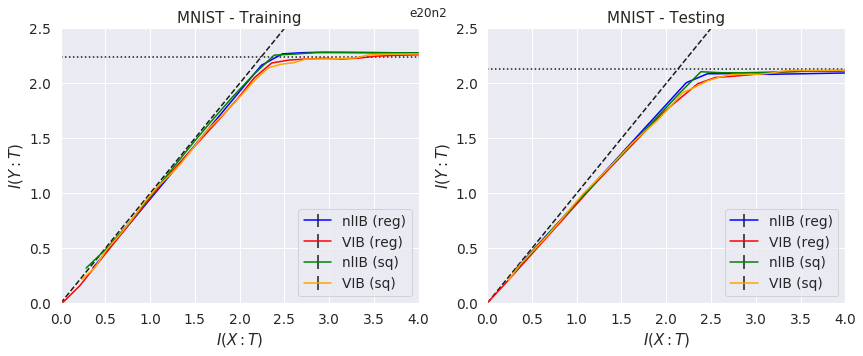

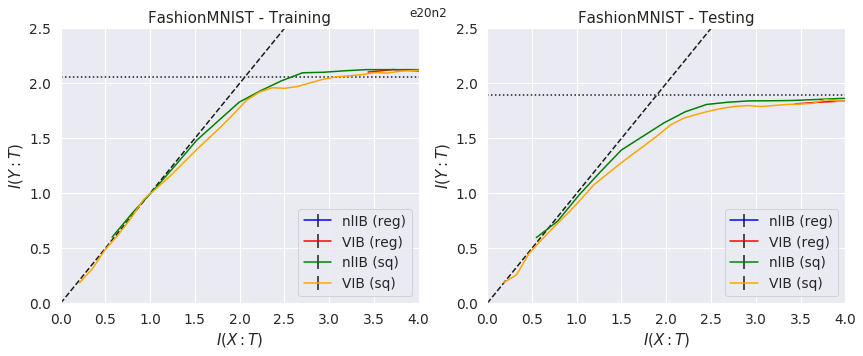

In [45]:
c = '/home/artemy/nonlinearIB/code/savedata-final40'
#sess  = tf.Session(config=tf.ConfigProto())
for runtype in [ 'MNIST', 'FashionMNIST','Housing', ]:
    for cdir in os.listdir(c):
        if cdir.endswith('sq'):
            continue
            
        if cdir.endswith('50'):
            continue
            
        if not cdir.startswith('e20'):
            continue
            
        basedir          = os.path.join(c, cdir, runtype)
        basedirsq        = os.path.join(c, cdir + 'sq', runtype)
        
        if not os.path.exists(basedir):
            continue

        data             = loaddata.load_data(runtype, validation='True')

        tf.reset_default_graph()
        with tf.Session() as sess:
            baseline_results = loadresults(sess, data, basedir, 'basemodel')
            run_results      = {}
            for run in range(maxruns):
                res    = loadresults(sess, data, basedir  , 'run'+str(run))
                res_sq = loadresults(sess, data, basedirsq, 'run'+str(run))
                for m in res_sq.keys():
                    res[m] = res_sq[m]
                if res is not None:
                    run_results['run'+str(run)] = res
                    
                else:
                    break
        plotresults(baseline_results, run_results)
        plt.suptitle(cdir)
        #asdfsdaf